In [2]:

# TODO: Fetch_News Subject 분석하기
import numpy as np
import re
import pickle
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# %cd '/content/drive/MyDrive/Colab Notebooks'

# news data를 읽어온다. subject 분석용.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))

# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n=0
print(len(news))
print(news[n])
print('topic = ', topic[n], topic_name[topic[n]])

# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')  # find는 문자열중에 특정문자를 찾고 위치를 반환해준다, 없을경우 -1을 리턴
        if idx >= 0:       # found
            subjects.append(sent[(idx + 9):].replace('Re: ', ''))
            break

# subject를 전처리한다.
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

# 1. 영문자가 아닌 문자를 모두 제거한다.
subject1 = [re.sub("[^a-zA-Z]", " ", s) for s in subjects]

# 2. 불용어를 제거하고, 모든 단어를 소문자로 변환하고, 길이가 2 이하인 
# 단어를 제거한다
# 3. Porterstemmer를 적용한다.
subject2 = []
for sub in subject1:
    tmp = []
    for w in sub.split():
        w = w.lower()
        if len(w) > 2 and w not in stop_words:
            tmp.append(stemmer.stem(w))
    subject2.append(' '.join(tmp))

# news data를 다시 읽어온다. news의 body 부분 처리.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
news = newsData['data']

# body 부분을 전처리한다.

# 1. 영문자가 아닌 문자를 모두 제거한다.
news1 = [re.sub("[^a-zA-Z]", " ", s) for s in subjects]

# 2. 불용어를 제거하고, 모든 단어를 소문자로 변환하고, 길이가 3 이하인 
# 단어를 제거한다
# 3. Porterstemmer를 적용한다.
news2 = []
for doc in news1:
    doc1 = []
    for w in doc.split():
        w = w.lower()
        if len(w) > 3 and w not in stop_words:
            doc1.append(stemmer.stem(w))
    news2.append(' '.join(doc1))

# 전처리가 완료된 데이터를 저장한다.
with open('/content/drive/MyDrive/Colab Notebook/data/newsgroup20.pkl', 'wb') as f:
    pickle.dump([subject2, news2, topic], f, pickle.DEFAULT_PROTOCOL)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
11314
From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15
topic =  17 talk.politics.mideast


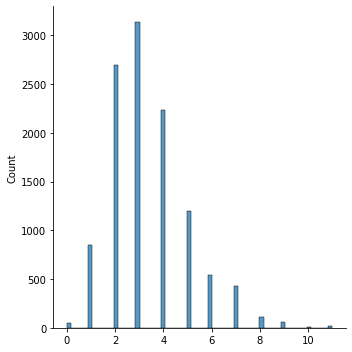

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 6, 32)             160064    
_________________________________________________________________
dropout (Dropout)            (None, 6, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 186,196
Trainable params: 186,196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
18/18 [==============================] - 4s 83ms/step - loss: 2.8570 - val_loss: 2.2311
Epoch 2/30
18/18 [====

In [3]:

# TODO: news_fetch LSTM
# LSTM으로 subject를 clasification한다.
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# %cd '/content/drive/MyDrive/Colab Notebooks'

# 전처리가 완료된 한글 코퍼스를 읽어온다.
with open('/content/drive/MyDrive/Colab Notebook/data/newsgroup20.pkl', 'rb') as f:
    subject, text, topic = pickle.load(f)

n_topic = len(set(topic))

max_word = 5000
tokenizer = Tokenizer(num_words = max_word, oov_token = '<OOV>')
tokenizer.fit_on_texts(subject)
sent_idx = tokenizer.texts_to_sequences(subject)
word2idx = {k:v for (k, v) in list(tokenizer.word_index.items())[:max_word]}
word2idx['<PAD>'] = 0
idx2word = {v:k for (k, v) in word2idx.items()}

# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in sent_idx]
sns.displot(n_len)
plt.show()

# 문장의 길이를 6으로 맞춘다.
x_data = pad_sequences(sent_idx, maxlen=6, padding='post', truncating='post')
y_data = topic

# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

# LSTM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation = 'softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01))
model.summary()

# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 30)



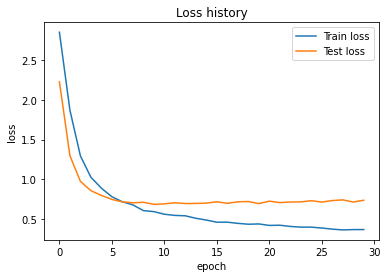

In [4]:

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [5]:

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))



Accuracy = 84.62 %


In [6]:

# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
mis_idx = [list(x_test[m]) for m in np.where(y_pred != y_test)[0]]

mis_sent = []
for sent in mis_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    mis_sent.append(tmp)
mis_sent[:10]


[['south', '<OOV>', '<OOV>'],
 ['last'],
 ['chrysler', 'bailout'],
 ['newss'],
 ['much', 'infinit', 'patienc'],
 ['infin', 'doppelgang', 'vulcan'],
 ['tempest'],
 ['left', 'side', 'pain'],
 ['striato', 'nigral', 'degener'],
 ['clarif', 'easter']]

[['atheist', 'view', 'christian', 'accept', 'jeesu', 'heart'], ['monophysit', 'mike', 'walker'], ['jeep', 'grand', 'toyota', 'runner'], ['null', 'modem', 'cabl'], ['armenia', 'say', 'could', 'shoot', 'turkish', 'plane'], ['limit', 'govt', 'employ', 'concentr'], ['page', 'flip', 'vga', 'mode'], ['qualiti', 'control', 'medicin'], ['ssto', 'senatori', 'aid', 'breif', 'recollect'], ['manual', 'shift', 'bigot']]



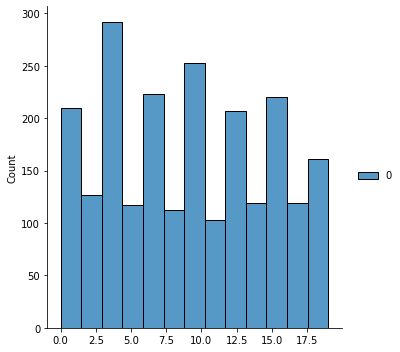

In [9]:

# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
good_idx = [list(x_test[m]) for m in np.where(y_pred == y_test)[0]]

good_sent = []
for sent in good_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    good_sent.append(tmp)
print(good_sent[:10])
print()

sns.displot(y_pred)
plt.show()

In [10]:
# Latent Semantic Analysis (LSA)
import numpy as np
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [12]:
# 전처리가 완료된 한글 코퍼스를 읽어온다.
with open('/content/drive/MyDrive/Colab Notebook/data/newsgroup20.pkl', 'rb') as f:
    subject, text, target = pickle.load(f)

n_target = len(set(target))

In [13]:

# TF-IDF matrix를 생성한다.
tf_vector = TfidfVectorizer(max_features = 500)
tfidf = tf_vector.fit_transform(text)
print(tfidf.shape)

vocab = tf_vector.get_feature_names()
print(vocab[:20])

(11314, 500)
['acceler', 'accept', 'access', 'address', 'advertis', 'advic', 'agnost', 'albican', 'algorithm', 'almost', 'altern', 'amend', 'american', 'ancient', 'anecdot', 'anim', 'announc', 'anoth', 'answer', 'anti']


In [14]:

# Latent Semantic Analysis (LSA)
# ------------------------------
svd = TruncatedSVD(n_components = n_target, n_iter=1000)
svd.fit(tfidf)

U = svd.fit_transform(tfidf) / svd.singular_values_
VT = svd.components_
S = np.diag(svd.singular_values_)
U.shape, S.shape, VT.shape

((11314, 20), (20, 20), (20, 500))

In [15]:
# 문서 별 Topic 번호를 확인한다. (문서 10개만 확인)
for i in range(10):
    print('문서-{:d} : topic = {:02d}, target = {:02d}'.format(i, np.argmax(U[i:(i+1), :][0]), target[i]))


문서-0 : topic = 01, target = 17
문서-1 : topic = 10, target = 00
문서-2 : topic = 01, target = 17
문서-3 : topic = 09, target = 11
문서-4 : topic = 19, target = 10
문서-5 : topic = 13, target = 15
문서-6 : topic = 13, target = 04
문서-7 : topic = 01, target = 17
문서-8 : topic = 18, target = 13
문서-9 : topic = 01, target = 12


In [17]:
# VT 행렬에서 topic 별로 중요 단어를 표시한다
for i in range(len(VT)):
    idx = VT[i].argsort()[::-1][:10]
    print('토픽-{:2d} : '.format(i+1), end='')
    for n in idx:
        print('{:s} '.format(vocab[n]), end='')
    print()

토픽- 1 : sale question window game system movi softwar card book updat 
토픽- 2 : question window moral christian wire israel help isra ask frequent 
토픽- 3 : help need window problem info want pleas file graphic drive 
토픽- 4 : window manag problem mous news applic driver forc screen accept 
토픽- 5 : christian moral year arrog good atheist need code tap polit 
토픽- 6 : good code tap need clipper info problem chip polit neighbor 
토픽- 7 : need info problem want clipper advic chip cheap secur card 
토픽- 8 : problem scsi drive quadra armenian video centri color plu lciii 
토픽- 9 : want card opinion chip monitor control info clipper driver like 
토픽-10 : clipper chip announc white hous text encrypt secret algorithm escrow 
토픽-11 : atheist polit hell agnost moral death test object hypocrisi neighbor 
토픽-12 : space read pleas warn drive mani station news post member 
토픽-13 : drive hard scsi disk boot secur updat tape forsal cheap 
토픽-14 : card like american express video pleas drive control monitor gr

In [18]:
# Latent Dirichlet Allocation (LDA)

import numpy as np
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [20]:
# TF-IDF matrix를 생성한다.
tf_vector = TfidfVectorizer(max_features = 500)
tfidf = tf_vector.fit_transform(text)
print(tfidf.shape)

vocab = tf_vector.get_feature_names()
print(vocab[:20])

(11314, 500)
['acceler', 'accept', 'access', 'address', 'advertis', 'advic', 'agnost', 'albican', 'algorithm', 'almost', 'altern', 'amend', 'american', 'ancient', 'anecdot', 'anim', 'announc', 'anoth', 'answer', 'anti']


In [21]:
model = LDA(n_components = n_target, 
            learning_method='online', 
            evaluate_every=5, 
            max_iter=1000, 
            verbose=1)

In [22]:
doc_topic = model.fit_transform(tfidf)


iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000, perplexity: 728.2822
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000, perplexity: 727.1560
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000, perplexity: 726.8444
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000, perplexity: 726.7045
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000, perplexity: 726.6263


In [23]:
# topic_term 행렬에서 topic 별로 중요 단어를 표시한다
topic_term = model.components_
for i in range(len(topic_term)):
    idx = np.flipud(topic_term[i].argsort())[:10]
    print('토픽-{:2d} : '.format(i+1), end='')
    for n in idx:
        print('{:s} '.format(vocab[n]), end='')
    print()

토픽- 1 : monitor game simm program centri manag upgrad ride real size 
토픽- 2 : read pleas player predict basebal jewish playoff warn price member 
토픽- 3 : card driver look like video american advic imag comput studi 
토픽- 4 : clinton use printer electron nation idea widget intern suppli score 
토픽- 5 : question scsi sensit superstit burn right dividian trade ranch messag 
토픽- 6 : isra team realli armenian food terror record radar detector press 
토픽- 7 : updat name best moon date screen love get easter commerci 
토픽- 8 : sale islam work color arrog find rushdi line number christian 
토픽- 9 : time news next genocid mormon could concept jew turkish automot 
토픽-10 : window control mous appl disk font vandal tape motif gateway 
토픽-11 : problem space chang mani sourc data station licens protect serial 
토픽-12 : long quadra race doubl sound answer biblic speed nuclear detect 
토픽-13 : hezbollah forsal waco request softwar batf final april cryptographi homosexu 
토픽-14 : drive hard secret insur point 

In [24]:
# Latent Dirichlet Allocation (LDA)
# ---------------------------------
import numpy as np
import pickle
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models.ldamodel import LdaModel as LDA

In [25]:
# doc2bow 생성
text_tok = [t.split() for t in text]
vocab = corpora.Dictionary(text_tok)
dict(list(vocab.items())[:10])
news_bow = [vocab.doc2bow(s) for s in text_tok]
print(news_bow[0])

[(0, 1), (1, 1)]


In [26]:
# Latent Dirichlet Allocation (LDA)
# ---------------------------------
model = LDA(news_bow, num_topics = n_target, id2word=vocab)

In [27]:
# 문서 별 Topic 번호를 확인한다. (문서 10개만 확인)
doc_topic = model.get_document_topics(news_bow)
for i in range(10):
    dp = np.array(doc_topic[i])
    most_likely_topic = int(dp[np.argmax(dp[:, 1]), 0])
    print('문서-{:d} : topic = {:02d}, target = {:02d}'.format(i, most_likely_topic, target[i]))


문서-0 : topic = 17, target = 17
문서-1 : topic = 18, target = 00
문서-2 : topic = 17, target = 17
문서-3 : topic = 10, target = 11
문서-4 : topic = 14, target = 10
문서-5 : topic = 15, target = 15
문서-6 : topic = 19, target = 04
문서-7 : topic = 14, target = 17
문서-8 : topic = 19, target = 13
문서-9 : topic = 10, target = 12


In [28]:
# topic_term 행렬에서 topic 별로 중요 단어를 표시한다
topic_term = model.get_topic_terms(0, topn=10)
for i in range(n_target):
    topic_term = model.get_topic_terms(i, topn=10)
    idx = [idx for idx, score in topic_term]
    print('토픽-{:2d} : '.format(i+1), end='')
    for n in idx:
        print('{:s} '.format(vocab[n]), end='')
    print()


토픽- 1 : graphic waco look studi batf murder today everyon almost percentag 
토픽- 2 : read pleas game final warn orbit know presid space messag 
토픽- 3 : player updat clinton jewish basebal opinion diamond program data get 
토픽- 4 : long part first give radar detector moon fast anim billion 
토픽- 5 : info good need book gateway scienc tradit riddanc homeopathi methodolog 
토픽- 6 : problem centri need imag color price advic test drive health 
토픽- 7 : time clipper realli best secur need sale automot concept dumbest 
토픽- 8 : help file need armenian window peopl keep licens kill marri 
토픽- 9 : softwar driver genocid memori heart accept worst insur ultra opinion 
토픽-10 : card american like express christian mani arrog video tape comput 
토픽-11 : clipper chip announc white hous text question encrypt answer use 
토픽-12 : mous post order pleas counterst space news avail press russian 
토픽-13 : plu work stat radio ride screen christian score trade minu 
토픽-14 : question hockey sale open serial letter re